<a href="https://colab.research.google.com/github/monimoyd/PredictingMaskAndDepthUsingDeepLearning/blob/master/assignment15_final_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment15
# Predicting Mask and Depth of image

In this project given background image and foreground image superimposed on background image, need to predict the mask and depth of image. The data is take 

I have used dataset from URL that was generated as part of 15A assignment: 
https://drive.google.com/drive/folders/1YF4HvfTdDwDLYPmBokx4b5QzInMVyAzA?usp=sharing

Used UNet model but reduced the parameters using Depthwise Separable convolution.

For profiling, I have used tensorboard, cprofiler, GPU profiler



In [0]:
from psutil import virtual_memory
print(virtual_memory().total / 1e9)
!nvidia-smi

27.3937408
Sat May 23 20:18:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory

## Mount the google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Copy the API codes locally

In [0]:
!cp -rf '/content/drive/My Drive/eva4_phase1_project_code/data_loaders' '/content'
!cp -rf '/content/drive/My Drive/eva4_phase1_project_code/data_transformations' '/content'
!cp -rf '/content/drive/My Drive/eva4_phase1_project_code/models' '/content'
!cp -rf '/content/drive/My Drive/eva4_phase1_project_code/utils' '/content'
! ls '/content'

data	      data_transformations  models  sample_data
data_loaders  drive		    runs    utils


## Import all the libraries needed

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader
import os
from PIL import Image as PILImage
import torchvision.transforms as transforms
from time import time
import numpy as np

from data_transformations.fg_bg_images_data_transformation import get_train_transform, get_test_transform
from data_loaders.fg_bg_images_data_loader import TrainImageDataset,TestImageDataset
from models.unet_model_small import UNet
from utils.train_test_util import train,test
from utils.plot_util import draw_and_save
from utils.iou_util import calculateIoU
from utils.ssim_util import SSIM
torch.manual_seed(5)
np.random.seed(5)

## Copy all the batch zip files to localy to /content/data folder

In [0]:
copy_start_time = time()
! mkdir -p /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch1_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch2_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch3_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch4_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch5_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch6_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch7_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch8_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch9_images.zip' /content/data
!cp '/content/drive/My Drive/latest_eva4_phase1_project_images/batch10_images.zip' /content/data
! ls /content/data
copy_end_time=time()

print("Total time taken for copying zip files: ", (copy_end_time - copy_start_time ))

batch10_images.zip  batch3_images.zip  batch6_images.zip  batch9_images.zip
batch1_images.zip   batch4_images.zip  batch7_images.zip
batch2_images.zip   batch5_images.zip  batch8_images.zip
Total time taken for copying zip files:  128.2801535129547


## Unzip all the batch zip files

In [0]:
unzip_start_time = time()

!mkdir -p '/content/data/batch1' '/content/data/batch2' '/content/data/batch3' '/content/data/batch4' '/content/data/batch5'
!mkdir -p '/content/data/batch6' '/content/data/batch7' '/content/data/batch8' '/content/data/batch9' '/content/data/batch10'

!unzip -qq '/content/data/batch1_images.zip' -d '/content/data/batch1'
!unzip -qq '/content/data/batch2_images.zip' -d '/content/data/batch2'
!unzip -qq '/content/data/batch3_images.zip' -d '/content/data/batch3'
!unzip -qq '/content/data/batch4_images.zip' -d '/content/data/batch4'
!unzip -qq '/content/data/batch5_images.zip' -d '/content/data/batch5'
!unzip -qq '/content/data/batch6_images.zip' -d '/content/data/batch6'
!unzip -qq '/content/data/batch7_images.zip' -d '/content/data/batch7'
!unzip -qq '/content/data/batch8_images.zip' -d '/content/data/batch8'
!unzip -qq '/content/data/batch9_images.zip' -d '/content/data/batch9'
!unzip -qq '/content/data/batch10_images.zip' -d '/content/data/batch10'

unzip_end_time = time()

print("Total time taken for unzipping zip files: ", (unzip_end_time - unzip_start_time ))

Total time taken for unzipping zip files:  155.29554629325867


## Remove the zip files copied

In [0]:
!rm /content/data/batch1_images.zip /content/data/batch2_images.zip /content/data/batch3_images.zip /content/data/batch4_images.zip /content/data/batch5_images.zip
!rm /content/data/batch6_images.zip /content/data/batch7_images.zip /content/data/batch8_images.zip /content/data/batch9_images.zip /content/data/batch10_images.zip


## Create directories where models, plots, tensorboard, cprofile stats will be stored

In [0]:
! mkdir -p '/content/drive/My Drive/eva4_final_project/final_api/models'
! mkdir -p '/content/drive/My Drive/eva4_final_project/final_api/train/plots'
! mkdir -p '/content/drive/My Drive/eva4_final_project/final_api/test/plots'
! mkdir -p '/content/drive/My Drive/eva4_final_project/final_api/cprofile_stats'
! mkdir -p '/content/drive/My Drive/eva4_final_project/final_api/tensor_board_stats'


## Start cprofile

In [0]:
import cProfile, pstats, io
pr = cProfile.Profile()
pr.enable()

In [0]:
TRAIN_PLOT_PATH="/content/drive/My Drive/eva4_final_project/final_api/train/plots"
TEST_PLOT_PATH="/content/drive/My Drive/eva4_final_project/final_api/test/plots"
MODEL_PATH="/content/drive/My Drive/eva4_final_project/final_api/models"
CPROFILE_STATS_PATH="/content/drive/My Drive/eva4_final_project/final_api/cprofile_stats"

## Define all the hyperparameters used

In [0]:
#HYPER PARAMETERS
BATCH_SIZE=100
EPOCHS=5

## Define dataloaders for train and test

- 9 batches of image data are used for training purpose
- 1 batch of image data is used for testing purpose

In [0]:
import numpy as np
train_transform = get_train_transform()
test_transform = get_test_transform()
train_image_dataset = TrainImageDataset(root_dir='/content/data',no_of_batches=9, transform = train_transform )
test_image_dataset = TestImageDataset(root_dir='/content/data',no_of_batches=1, transform = test_transform )

train_dl = DataLoader(train_image_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
sample = next(iter(train_dl))
print(sample['bg'].shape, sample['fg_bg'].shape, sample['mask_black'].shape, sample['depth_fg_bg'].shape)

test_dl = DataLoader(test_image_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

torch.Size([100, 1, 160, 160]) torch.Size([100, 1, 160, 160]) torch.Size([100, 1, 160, 160]) torch.Size([100, 1, 80, 80])


## Display a few samples images from dataset

(-0.5, 649.5, 325.5, -0.5)

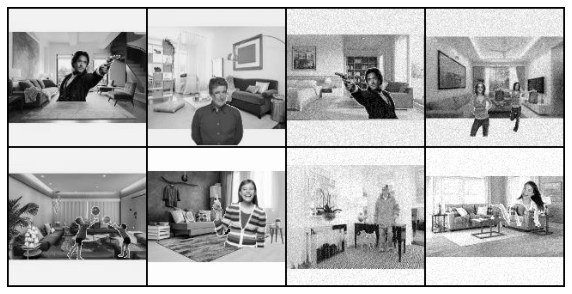

In [0]:
%matplotlib inline
import  torchvision
from matplotlib import pyplot as plt
imgs = sample['fg_bg'][:8];

grid_tensors = torchvision.utils.make_grid(imgs, 4)
grid_images = grid_tensors.permute(1,2,0)
plt.figure(figsize=(10,10))
plt.imshow(torch.clamp(grid_images, 0 , 1))
plt.axis('off')

## Install thop

In [0]:
# !pip install torchsummary
!pip install thop

## Summarize the parameters of UNet Model used

In [0]:
from torchsummary import summary
from thop import profile

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(2,160,80).to(device)
summary(model, input_size=[(1, 160, 160), (1,160,160)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 2, 160, 160]              20
            Conv2d-2         [-1, 32, 160, 160]              96
depthwise_separable_conv-3         [-1, 32, 160, 160]               0
       BatchNorm2d-4         [-1, 32, 160, 160]              64
              ReLU-5         [-1, 32, 160, 160]               0
            Conv2d-6         [-1, 32, 160, 160]             320
            Conv2d-7         [-1, 32, 160, 160]           1,056
depthwise_separable_conv-8         [-1, 32, 160, 160]               0
       BatchNorm2d-9         [-1, 32, 160, 160]              64
             ReLU-10         [-1, 32, 160, 160]               0
       DoubleConv-11         [-1, 32, 160, 160]               0
        MaxPool2d-12           [-1, 32, 80, 80]               0
           Conv2d-13           [-1, 32, 80, 80]             320
           Conv2d-14       

## Calculate and display MACS value of the model

In [0]:
input = torch.randn(1,1, 160, 160).to(device), torch.randn(1,1, 160, 160).to(device)
macs, params = profile(model, inputs=(input))
print(" MACS: ", macs)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'models.unet_model_small.depthwise_separable_conv'>. Treat it as zero Macs and zero Params.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'models.unet_model_small.DoubleConv'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'models.unet_model_small.Down'>. Treat it as zero Macs and zero Params.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
[WARN] Cannot find rule for <class 'models.unet_model_small.Up'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'mod

## Perform training of the model and periodically display statistics, mask , depth images generated, IoU value

 For epoch:  1  after batch:  0  predicted mask IoU:  0.014231419562203909
 For epoch:  1  after batch:  100  predicted mask IoU:  0.743675240606092
 For epoch:  1  after batch:  200  predicted mask IoU:  0.8062300403544064
 For epoch:  1  after batch:  300  predicted mask IoU:  0.8564228411235658
 For epoch:  1  after batch:  400  predicted mask IoU:  0.8645377573730666
 For epoch:  1  after batch:  500  predicted mask IoU:  0.8927825108503457
 For epoch:  1  after batch:  600  predicted mask IoU:  0.8724294510615029
 For epoch:  1  after batch:  700  predicted mask IoU:  0.890748531878355
 For epoch:  1  after batch:  800  predicted mask IoU:  0.8984403677556491
 For epoch:  1  after batch:  900  predicted mask IoU:  0.8857530052020122
 For epoch:  1  after batch:  1000  predicted mask IoU:  0.8916444700405538
 For epoch:  1  after batch:  1100  predicted mask IoU:  0.8925530322376126
 For epoch:  1  after batch:  1200  predicted mask IoU:  0.9101467778282365
 For epoch:  1  after ba

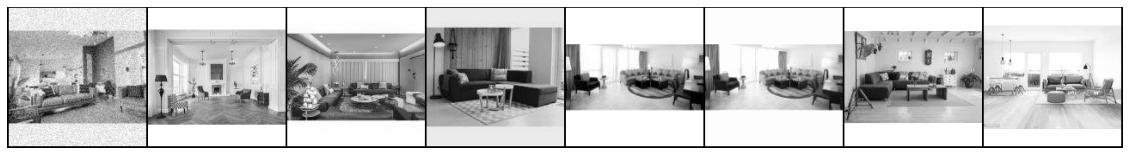

 For epoch:  1  after batch:  1799  Foreground superimposed on background images: 


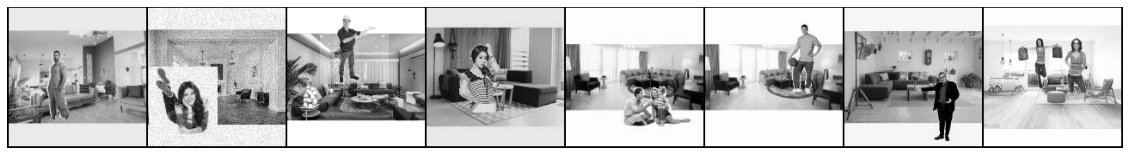

 For epoch:  1  after batch:  1799  predicted mask IoU:  0.9181050206786873
 For epoch:  1  after batch:  1799  Predicted mask images: 


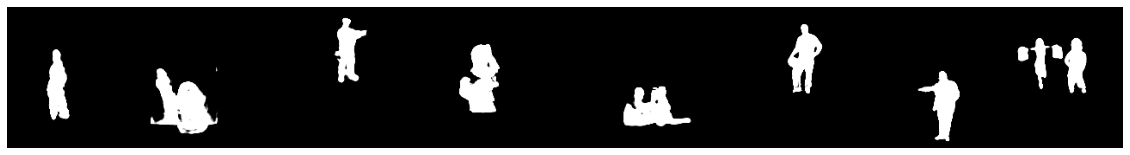

 For epoch:  1  after batch:  1799  Predicted depth images: 


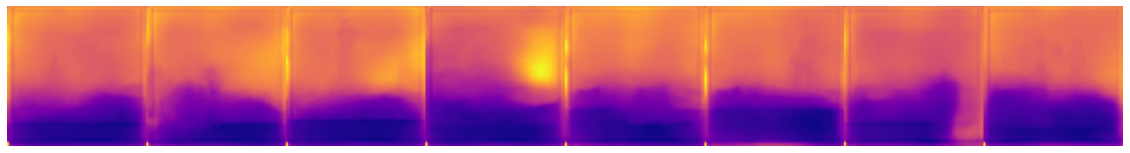

 For epoch:  1  after batch:  1800  predicted mask IoU:  0.9122440837410495
 For epoch:  1  after batch:  1900  predicted mask IoU:  0.920797576569147
 For epoch:  1  after batch:  2000  predicted mask IoU:  0.923670341421188
 For epoch:  1  after batch:  2100  predicted mask IoU:  0.9237826074436093
 For epoch:  1  after batch:  2200  predicted mask IoU:  0.9198810925124195
 For epoch:  1  after batch:  2300  predicted mask IoU:  0.9207909300060108
 For epoch:  1  after batch:  2400  predicted mask IoU:  0.9298091598442352
 For epoch:  1  after batch:  2500  predicted mask IoU:  0.9242739995256006
 For epoch:  1  after batch:  2600  predicted mask IoU:  0.9203788651387094
 For epoch:  1  after batch:  2700  predicted mask IoU:  0.9282118224836529
 For epoch:  1  after batch:  2800  predicted mask IoU:  0.93482328896203
 For epoch:  1  after batch:  2900  predicted mask IoU:  0.9150794810593145
 For epoch:  1  after batch:  3000  predicted mask IoU:  0.9358240292144344
 For epoch:  1  

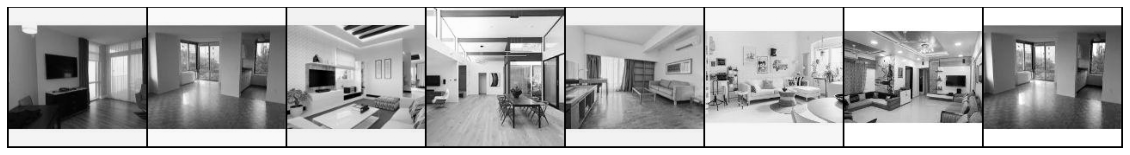

 For epoch:  1  after batch:  3599  Foreground superimposed on background images: 


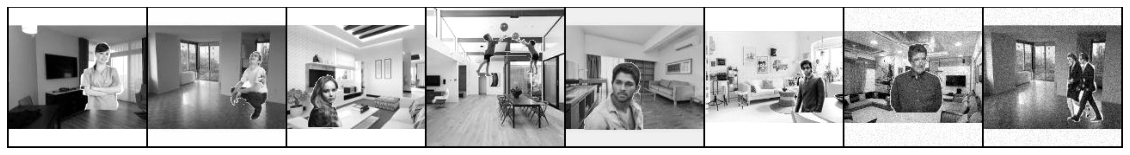

 For epoch:  1  after batch:  3599  predicted mask IoU:  0.9328328642295279
 For epoch:  1  after batch:  3599  Predicted mask images: 


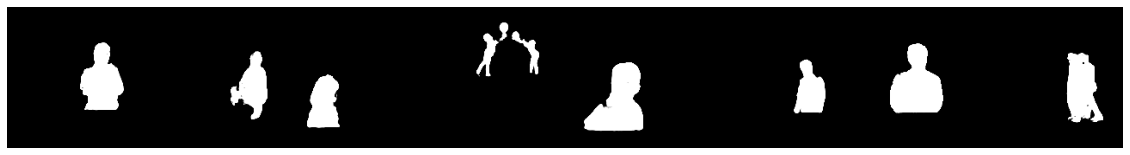

 For epoch:  1  after batch:  3599  Predicted depth images: 


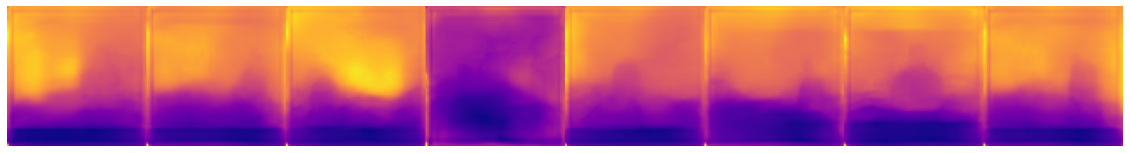


Epoch:  1  Training Time:  3600.63835811615  Data Loading Time:  10.604703187942505  Misc Time:  56.787678956985474


 For epoch:  2  after batch:  0  predicted mask IoU:  0.9349300305080249
 For epoch:  2  after batch:  100  predicted mask IoU:  0.9335394979086598
 For epoch:  2  after batch:  200  predicted mask IoU:  0.9308414560043949
 For epoch:  2  after batch:  300  predicted mask IoU:  0.9292374915758919
 For epoch:  2  after batch:  400  predicted mask IoU:  0.9324918597252891
 For epoch:  2  after batch:  500  predicted mask IoU:  0.9372752348756662
 For epoch:  2  after batch:  600  predicted mask IoU:  0.939004728477097
 For epoch:  2  after batch:  700  predicted mask IoU:  0.9367418612953845
 For epoch:  2  after batch:  800  predicted mask IoU:  0.9399507195599142
 For epoch:  2  after batch:  900  predicted mask IoU:  0.9343562667952869
 For epoch:  2  after batch:  1000  predicted mask IoU:  0.9346542052899988
 For epoch:  2  after batch:  1100  predicted mask IoU:  0.9479016093283222
 For epoch:  2  after batch:  1200  predicted mask IoU:  0.9346451309661155
 For epoch:  2  after bat

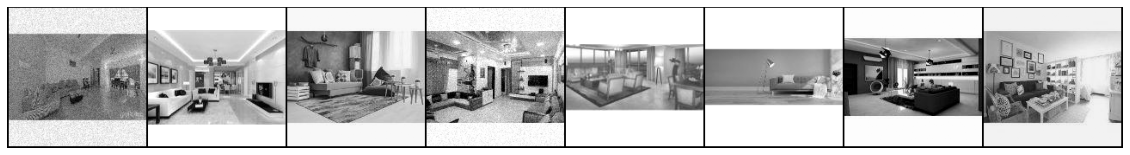

 For epoch:  2  after batch:  1799  Foreground superimposed on background images: 


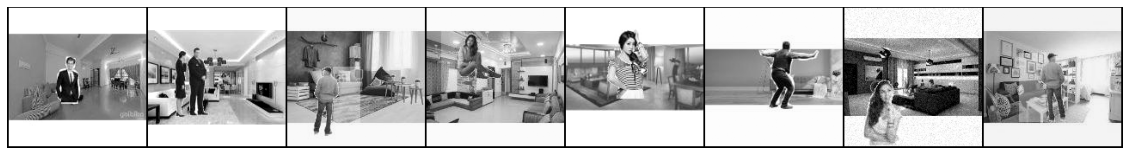

 For epoch:  2  after batch:  1799  predicted mask IoU:  0.9337931265379915
 For epoch:  2  after batch:  1799  Predicted mask images: 


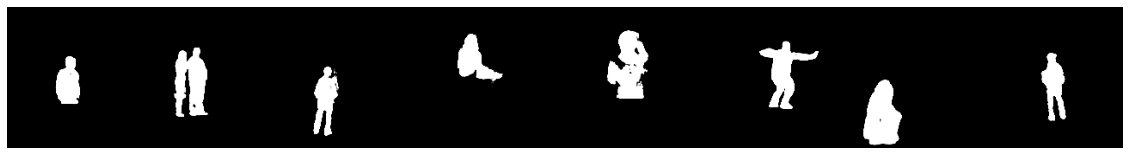

 For epoch:  2  after batch:  1799  Predicted depth images: 


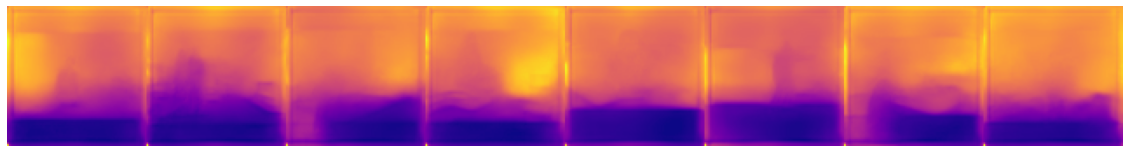

 For epoch:  2  after batch:  1800  predicted mask IoU:  0.9386195654187429
 For epoch:  2  after batch:  1900  predicted mask IoU:  0.9393630943725462
 For epoch:  2  after batch:  2000  predicted mask IoU:  0.9386148272017837
 For epoch:  2  after batch:  2100  predicted mask IoU:  0.9413624604771486
 For epoch:  2  after batch:  2200  predicted mask IoU:  0.9362092536506874
 For epoch:  2  after batch:  2300  predicted mask IoU:  0.9282787381123309
 For epoch:  2  after batch:  2400  predicted mask IoU:  0.9332475325088994
 For epoch:  2  after batch:  2500  predicted mask IoU:  0.9426440056213885
 For epoch:  2  after batch:  2600  predicted mask IoU:  0.9386783503426124
 For epoch:  2  after batch:  2700  predicted mask IoU:  0.9435845699350411
 For epoch:  2  after batch:  2800  predicted mask IoU:  0.9432519847103793
 For epoch:  2  after batch:  2900  predicted mask IoU:  0.9463142283869842
 For epoch:  2  after batch:  3000  predicted mask IoU:  0.9448998421257663
 For epoch: 

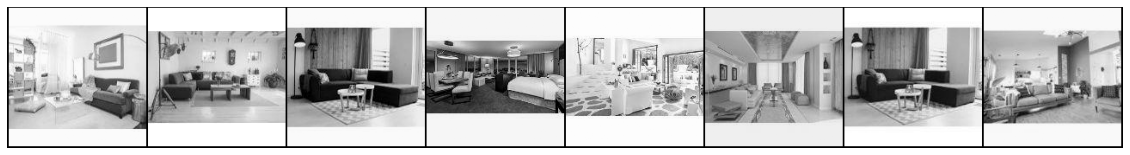

 For epoch:  2  after batch:  3599  Foreground superimposed on background images: 


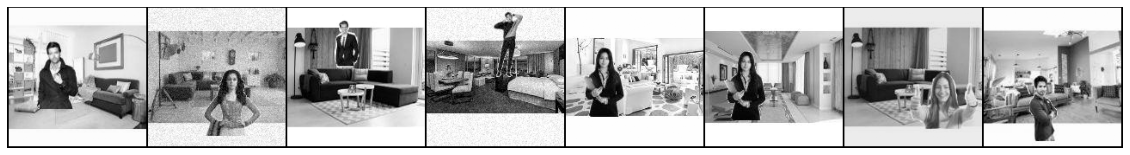

 For epoch:  2  after batch:  3599  predicted mask IoU:  0.9455891389898381
 For epoch:  2  after batch:  3599  Predicted mask images: 


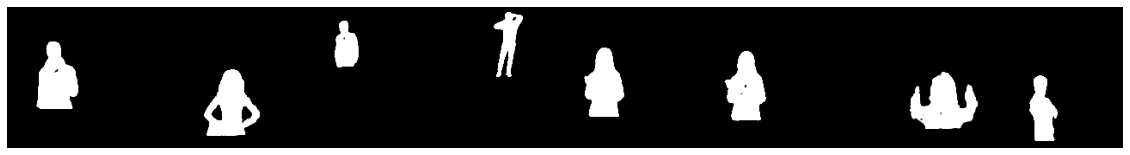

 For epoch:  2  after batch:  3599  Predicted depth images: 


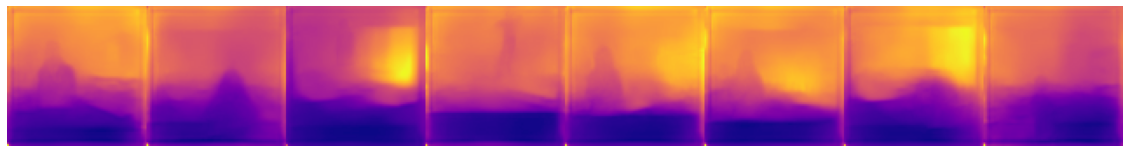


Epoch:  2  Training Time:  3622.2514436244965  Data Loading Time:  10.590641975402832  Misc Time:  59.93659019470215


 For epoch:  3  after batch:  0  predicted mask IoU:  0.9409477158982004
 For epoch:  3  after batch:  100  predicted mask IoU:  0.9447849128104924
 For epoch:  3  after batch:  200  predicted mask IoU:  0.9423385076579729
 For epoch:  3  after batch:  300  predicted mask IoU:  0.9412096562582
 For epoch:  3  after batch:  400  predicted mask IoU:  0.9487292460978738
 For epoch:  3  after batch:  500  predicted mask IoU:  0.9456939546336679
 For epoch:  3  after batch:  600  predicted mask IoU:  0.9445134416518358
 For epoch:  3  after batch:  700  predicted mask IoU:  0.9423431115447948
 For epoch:  3  after batch:  800  predicted mask IoU:  0.9471720960953841
 For epoch:  3  after batch:  900  predicted mask IoU:  0.9432606612460774
 For epoch:  3  after batch:  1000  predicted mask IoU:  0.9434903140741743
 For epoch:  3  after batch:  1100  predicted mask IoU:  0.9417846169344684
 For epoch:  3  after batch:  1200  predicted mask IoU:  0.9450127877237852
 For epoch:  3  after batch

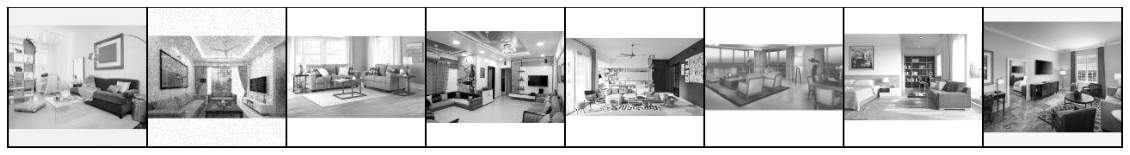

 For epoch:  3  after batch:  1799  Foreground superimposed on background images: 


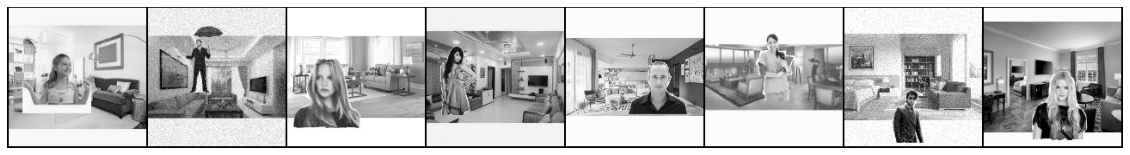

 For epoch:  3  after batch:  1799  predicted mask IoU:  0.9466233617832939
 For epoch:  3  after batch:  1799  Predicted mask images: 


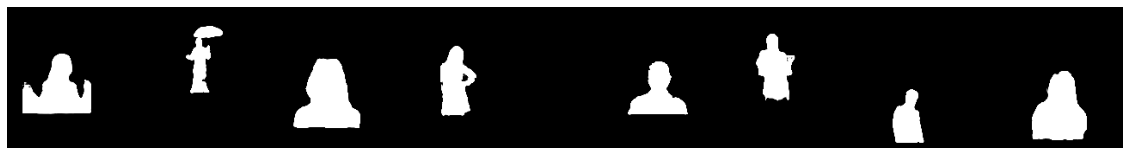

 For epoch:  3  after batch:  1799  Predicted depth images: 


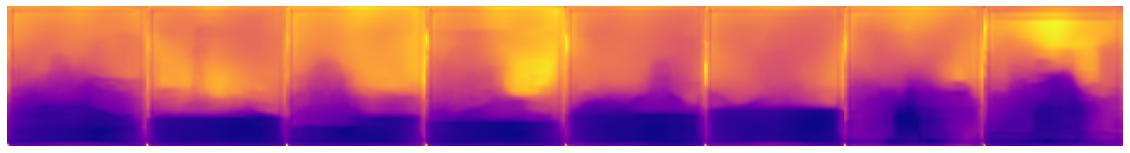

 For epoch:  3  after batch:  1800  predicted mask IoU:  0.9373069414584724
 For epoch:  3  after batch:  1900  predicted mask IoU:  0.9427889431171543
 For epoch:  3  after batch:  2000  predicted mask IoU:  0.9445860911518024
 For epoch:  3  after batch:  2100  predicted mask IoU:  0.9449912432097771
 For epoch:  3  after batch:  2200  predicted mask IoU:  0.93861154012347
 For epoch:  3  after batch:  2300  predicted mask IoU:  0.9426857271798139
 For epoch:  3  after batch:  2400  predicted mask IoU:  0.9433040598964844
 For epoch:  3  after batch:  2500  predicted mask IoU:  0.9458408660697195
 For epoch:  3  after batch:  2600  predicted mask IoU:  0.9489910766238123
 For epoch:  3  after batch:  2700  predicted mask IoU:  0.9465888534757516
 For epoch:  3  after batch:  2800  predicted mask IoU:  0.9440442527193543
 For epoch:  3  after batch:  2900  predicted mask IoU:  0.9469676197123414
 For epoch:  3  after batch:  3000  predicted mask IoU:  0.9430076920884285
 For epoch:  3

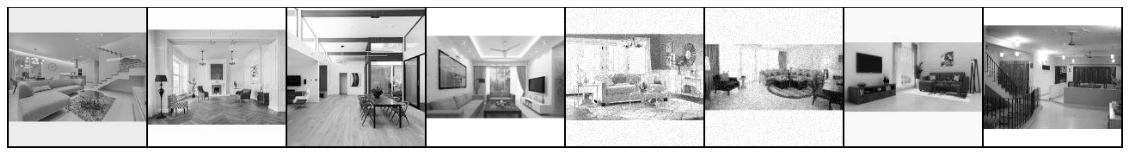

 For epoch:  3  after batch:  3599  Foreground superimposed on background images: 


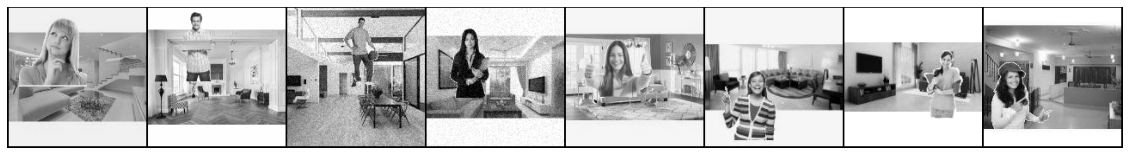

 For epoch:  3  after batch:  3599  predicted mask IoU:  0.9421658249450088
 For epoch:  3  after batch:  3599  Predicted mask images: 


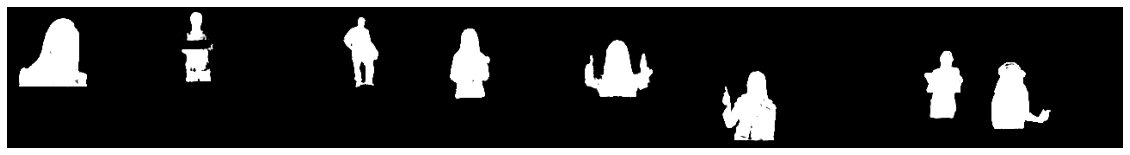

 For epoch:  3  after batch:  3599  Predicted depth images: 


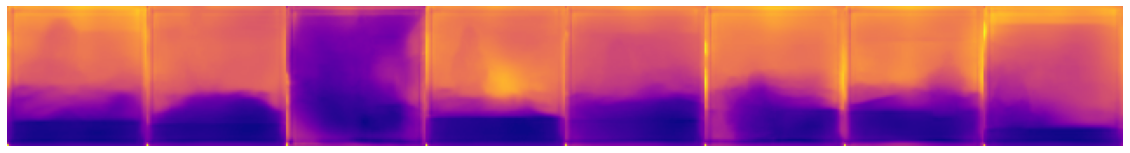


Epoch:  3  Training Time:  3626.0100643634796  Data Loading Time:  10.588401794433594  Misc Time:  60.445101261138916


 For epoch:  4  after batch:  0  predicted mask IoU:  0.9439296246733143
 For epoch:  4  after batch:  100  predicted mask IoU:  0.9483240050137133
 For epoch:  4  after batch:  200  predicted mask IoU:  0.9460173684023205
 For epoch:  4  after batch:  300  predicted mask IoU:  0.947983729307141
 For epoch:  4  after batch:  400  predicted mask IoU:  0.942519284231959
 For epoch:  4  after batch:  500  predicted mask IoU:  0.9437386261203803
 For epoch:  4  after batch:  600  predicted mask IoU:  0.9456577419575166
 For epoch:  4  after batch:  700  predicted mask IoU:  0.9418468372481846
 For epoch:  4  after batch:  800  predicted mask IoU:  0.9532941316631492
 For epoch:  4  after batch:  900  predicted mask IoU:  0.9424152314047938
 For epoch:  4  after batch:  1000  predicted mask IoU:  0.9473328187739032
 For epoch:  4  after batch:  1100  predicted mask IoU:  0.9410555350917018
 For epoch:  4  after batch:  1200  predicted mask IoU:  0.947689180129328
 For epoch:  4  after batch

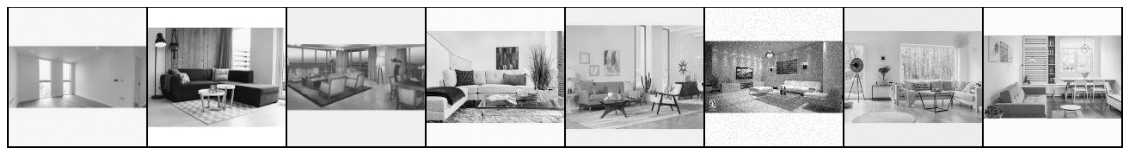

 For epoch:  4  after batch:  1799  Foreground superimposed on background images: 


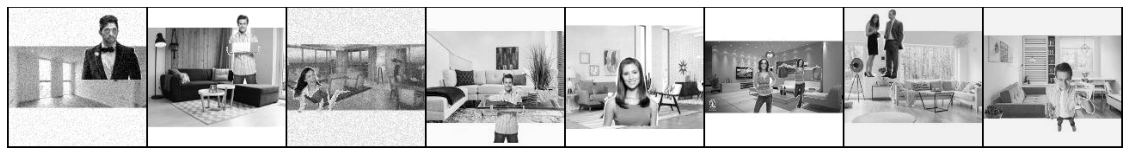

 For epoch:  4  after batch:  1799  predicted mask IoU:  0.9422367689214051
 For epoch:  4  after batch:  1799  Predicted mask images: 


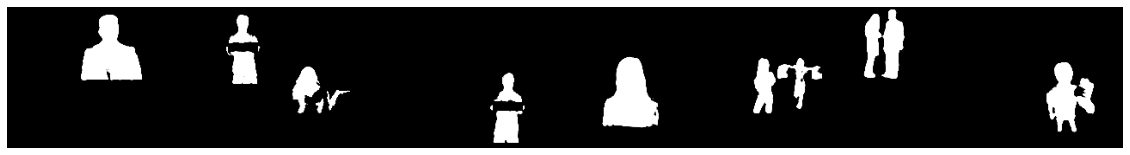

 For epoch:  4  after batch:  1799  Predicted depth images: 


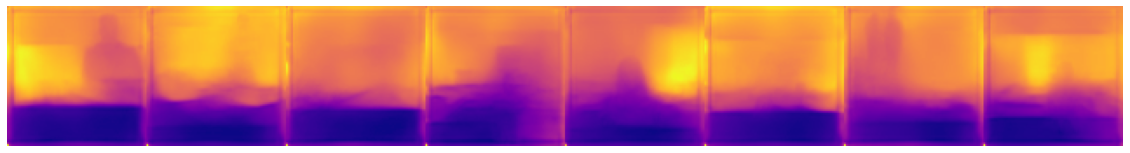

 For epoch:  4  after batch:  1800  predicted mask IoU:  0.9437856811442173
 For epoch:  4  after batch:  1900  predicted mask IoU:  0.9423644587030039
 For epoch:  4  after batch:  2000  predicted mask IoU:  0.9500202526223654
 For epoch:  4  after batch:  2100  predicted mask IoU:  0.9424227966689799
 For epoch:  4  after batch:  2200  predicted mask IoU:  0.945377443271175
 For epoch:  4  after batch:  2300  predicted mask IoU:  0.9505846994768142
 For epoch:  4  after batch:  2400  predicted mask IoU:  0.9421055989112638
 For epoch:  4  after batch:  2500  predicted mask IoU:  0.9486663483184392
 For epoch:  4  after batch:  2600  predicted mask IoU:  0.9412848539116884
 For epoch:  4  after batch:  2700  predicted mask IoU:  0.9496418714123643
 For epoch:  4  after batch:  2800  predicted mask IoU:  0.9459785062909389
 For epoch:  4  after batch:  2900  predicted mask IoU:  0.947693110820172
 For epoch:  4  after batch:  3000  predicted mask IoU:  0.9408592972565609
 For epoch:  4

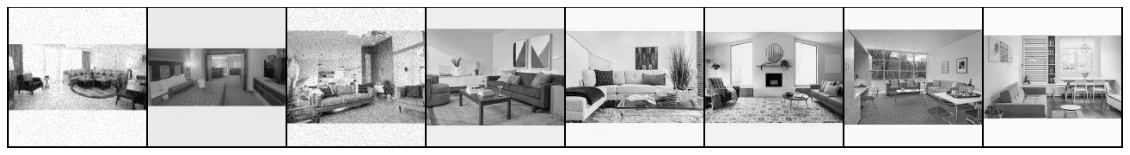

 For epoch:  4  after batch:  3599  Foreground superimposed on background images: 


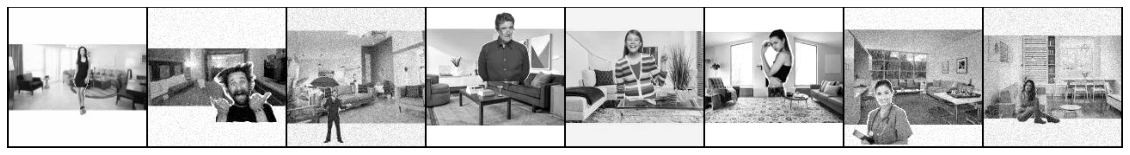

 For epoch:  4  after batch:  3599  predicted mask IoU:  0.9447407659864525
 For epoch:  4  after batch:  3599  Predicted mask images: 


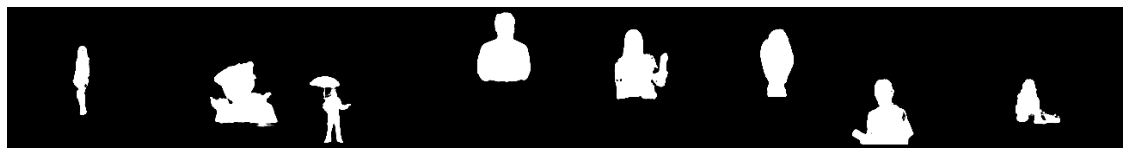

 For epoch:  4  after batch:  3599  Predicted depth images: 


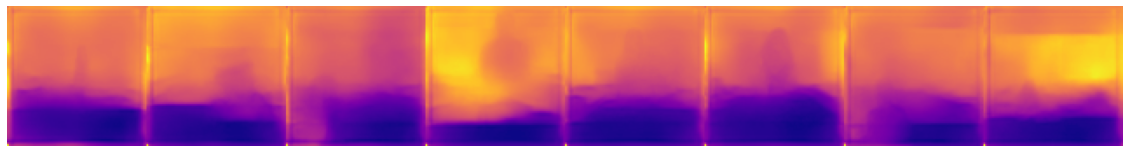


Epoch:  4  Training Time:  3661.500823497772  Data Loading Time:  10.634032964706421  Misc Time:  61.81038284301758


 For epoch:  5  after batch:  0  predicted mask IoU:  0.9443744578460305
 For epoch:  5  after batch:  100  predicted mask IoU:  0.9460576235176794
 For epoch:  5  after batch:  200  predicted mask IoU:  0.9506832828974334
 For epoch:  5  after batch:  300  predicted mask IoU:  0.9442581817395255
 For epoch:  5  after batch:  400  predicted mask IoU:  0.9497588575484894
 For epoch:  5  after batch:  500  predicted mask IoU:  0.9487869947889396
 For epoch:  5  after batch:  600  predicted mask IoU:  0.9450558137406232
 For epoch:  5  after batch:  700  predicted mask IoU:  0.9395196515590002
 For epoch:  5  after batch:  800  predicted mask IoU:  0.9460103795681999
 For epoch:  5  after batch:  900  predicted mask IoU:  0.9503073146100673
 For epoch:  5  after batch:  1000  predicted mask IoU:  0.9494145240754999
 For epoch:  5  after batch:  1100  predicted mask IoU:  0.9462114227537479
 For epoch:  5  after batch:  1200  predicted mask IoU:  0.9434850664184787
 For epoch:  5  after ba

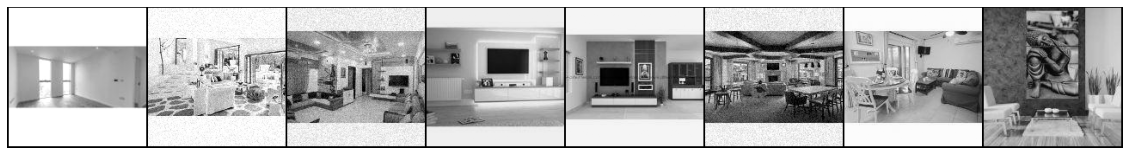

 For epoch:  5  after batch:  1799  Foreground superimposed on background images: 


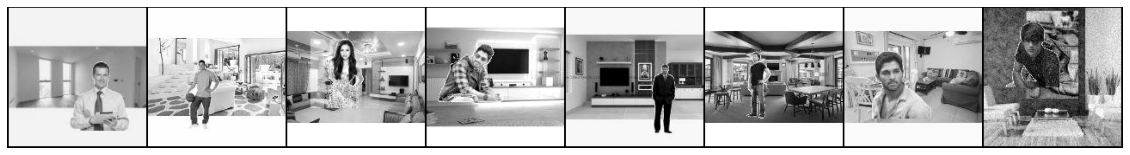

 For epoch:  5  after batch:  1799  predicted mask IoU:  0.9473572277475448
 For epoch:  5  after batch:  1799  Predicted mask images: 


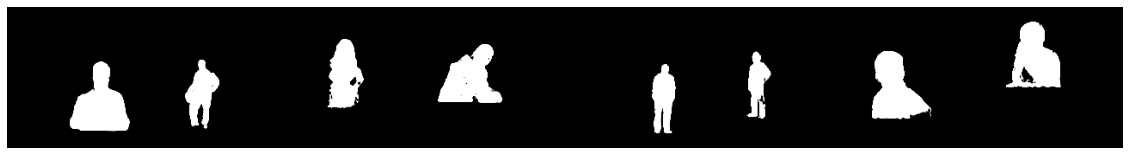

 For epoch:  5  after batch:  1799  Predicted depth images: 


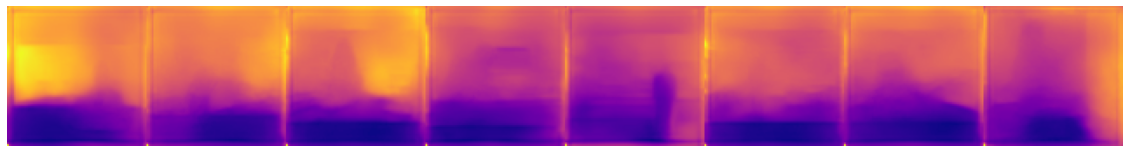

 For epoch:  5  after batch:  1800  predicted mask IoU:  0.9422098827884506
 For epoch:  5  after batch:  1900  predicted mask IoU:  0.9500225891418683
 For epoch:  5  after batch:  2000  predicted mask IoU:  0.9480115110628863
 For epoch:  5  after batch:  2100  predicted mask IoU:  0.9475382500190398
 For epoch:  5  after batch:  2200  predicted mask IoU:  0.94871728089595
 For epoch:  5  after batch:  2300  predicted mask IoU:  0.9501579619546952
 For epoch:  5  after batch:  2400  predicted mask IoU:  0.9503691673487228
 For epoch:  5  after batch:  2500  predicted mask IoU:  0.9455040181174422
 For epoch:  5  after batch:  2600  predicted mask IoU:  0.9461450247000706
 For epoch:  5  after batch:  2700  predicted mask IoU:  0.9479383538861444
 For epoch:  5  after batch:  2800  predicted mask IoU:  0.950239026510213
 For epoch:  5  after batch:  2900  predicted mask IoU:  0.9511306393635466
 For epoch:  5  after batch:  3000  predicted mask IoU:  0.945045627588097
 For epoch:  5  

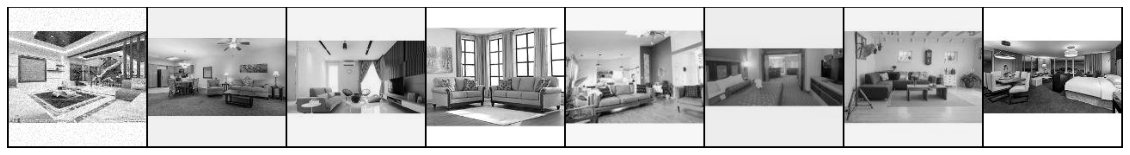

 For epoch:  5  after batch:  3599  Foreground superimposed on background images: 


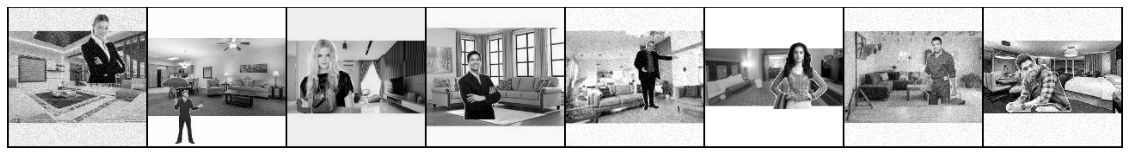

 For epoch:  5  after batch:  3599  predicted mask IoU:  0.947991789519313
 For epoch:  5  after batch:  3599  Predicted mask images: 


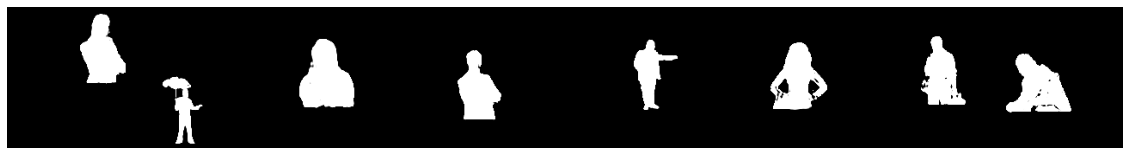

 For epoch:  5  after batch:  3599  Predicted depth images: 


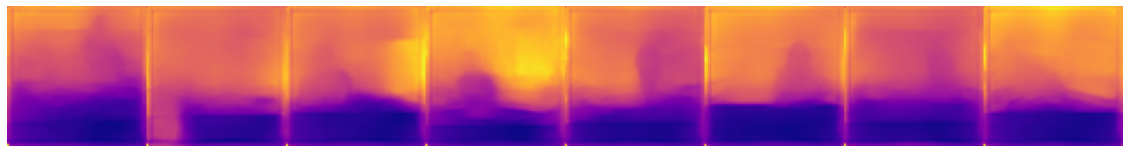


Epoch:  5  Training Time:  3653.637369155884  Data Loading Time:  10.622773170471191  Misc Time:  57.52307391166687


In [0]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

criteria1 = nn.BCEWithLogitsLoss()
criteria2 =  SSIM(window_size=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(2,160,80)

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)

from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
mem_log = []
for epoch in range(EPOCHS):
    time_measurements = [0.0, 0.0, 0.0]
    mlog = train(model,device, criteria1, criteria2, train_dl,optimizer, epoch, writer, MODEL_PATH,TRAIN_PLOT_PATH, time_measurements)
    mem_log.extend(mlog)
    scheduler.step()
    print("Epoch: ", (epoch + 1), " Training Time: ",time_measurements[0], " Data Loading Time: ", time_measurements[1], " Misc Time: ", time_measurements[2] )


## Convert mem_log from the GPU profiler to pandas dataframe

In [0]:
import pandas as pd
df = pd.DataFrame(mem_log)


## Testing

## Check all the model weights files generated during training are present

In [0]:
! ls -l '/content/drive/My Drive/eva4_final_project/final_api/models'

total 390735
-rw------- 1 root root 2105780 May 23 18:29 0_0.pth
-rw------- 1 root root 2105778 May 23 18:31 0_100.pth
-rw------- 1 root root 2105780 May 23 18:33 0_200.pth
-rw------- 1 root root 2105780 May 23 18:35 0_300.pth
-rw------- 1 root root 2105778 May 23 18:37 0_final.pth
-rw------- 1 root root 2105764 May 23 20:21 1_0.pth
-rw------- 1 root root 2105764 May 23 20:43 1_1000.pth
-rw------- 1 root root 2105764 May 23 20:23 1_100.pth
-rw------- 1 root root 2105764 May 23 20:46 1_1100.pth
-rw------- 1 root root 2105764 May 23 20:48 1_1200.pth
-rw------- 1 root root 2105764 May 23 20:50 1_1300.pth
-rw------- 1 root root 2105764 May 23 20:53 1_1400.pth
-rw------- 1 root root 2105762 May 23 20:55 1_1500.pth
-rw------- 1 root root 2105764 May 23 20:57 1_1600.pth
-rw------- 1 root root 2105764 May 23 20:59 1_1700.pth
-rw------- 1 root root 2105764 May 23 21:02 1_1800.pth
-rw------- 1 root root 2105764 May 23 21:04 1_1900.pth
-rw------- 1 root root 2105764 May 23 21:06 1_2000.pth
-rw---

## Load the best model and perform test and Test dataset and show results

In [0]:
TEST_MODEL_PATH=MODEL_PATH + "/5_final.pth"

 After iteration:  0  Background images: 


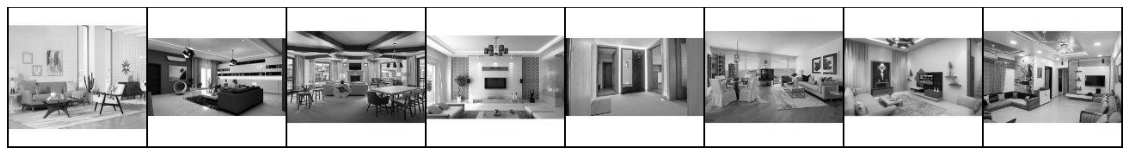

 After iteration:  0  foregound superimposed background images: 


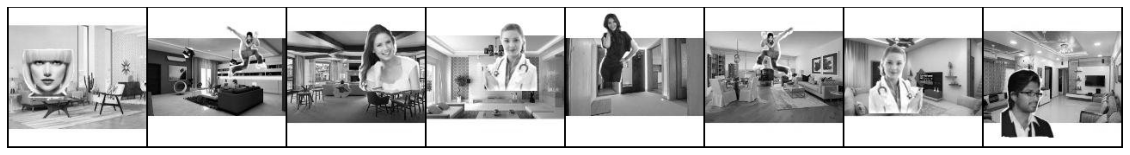

 After iteration:  0  ground truth  mask images:


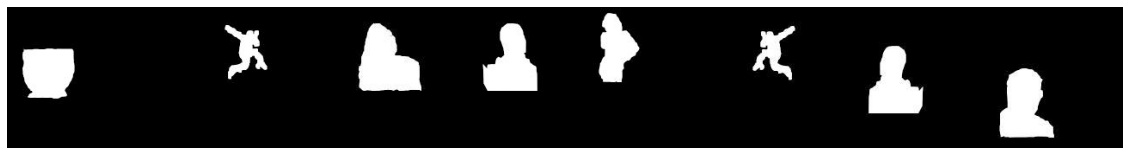

 After iteration:  0  Mask IoU: 0.9495709645481232
 After iteration:  0  predicted mask images:


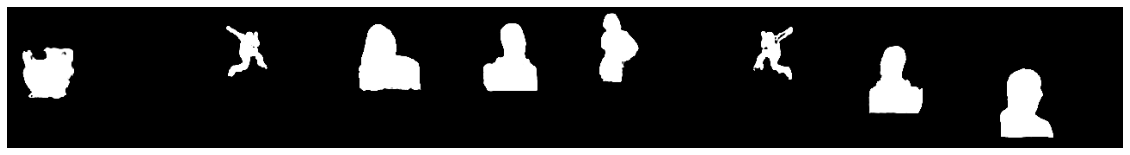

 After iteration:  0  ground truth depth images:


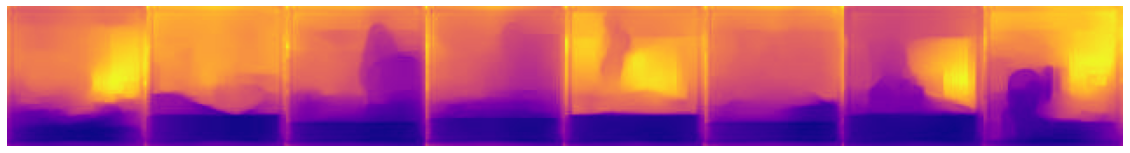

 After iteration:  0  predicted depth images:


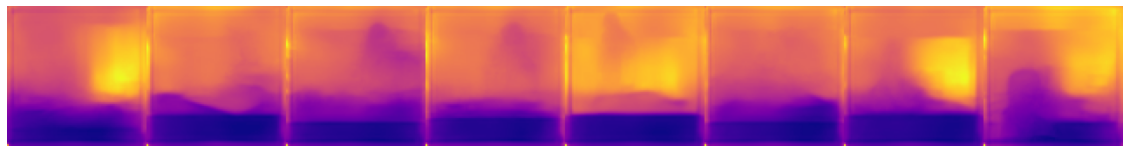

 After iteration:  100  Background images: 


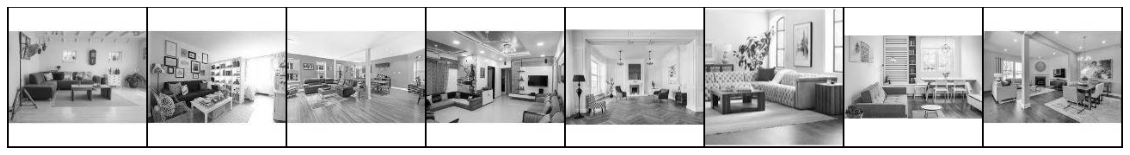

 After iteration:  100  foregound superimposed background images: 


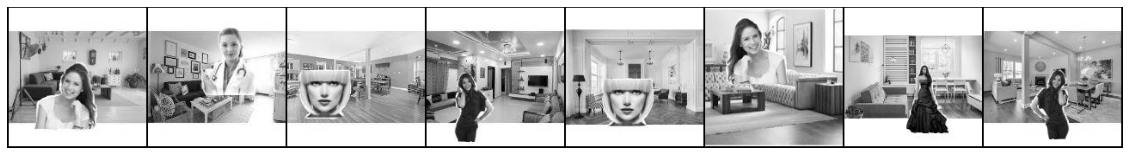

 After iteration:  100  ground truth  mask images:


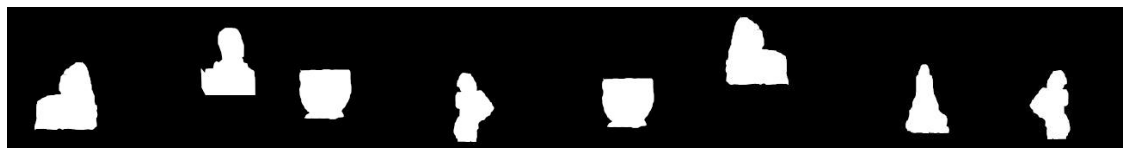

 After iteration:  100  Mask IoU: 0.9479997050558345
 After iteration:  100  predicted mask images:


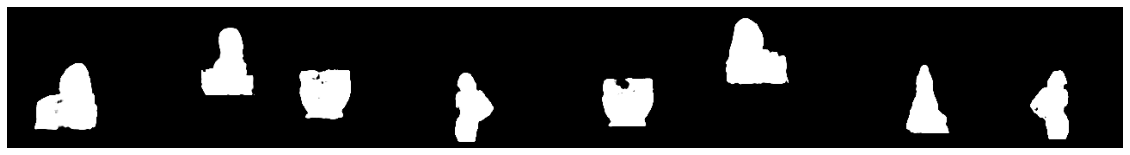

 After iteration:  100  ground truth depth images:


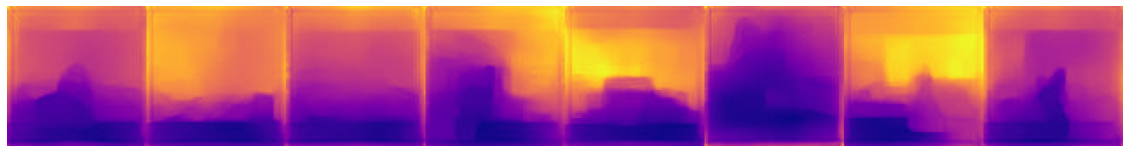

 After iteration:  100  predicted depth images:


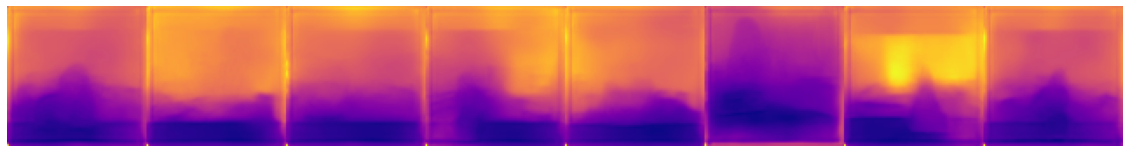

 After iteration:  200  Background images: 


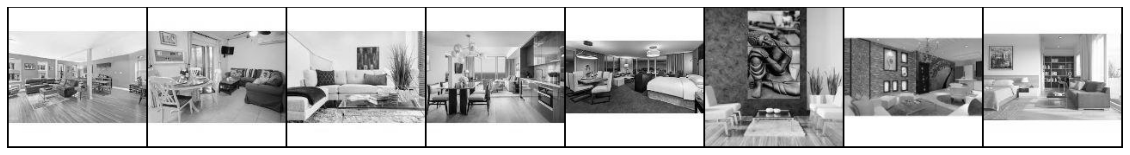

 After iteration:  200  foregound superimposed background images: 


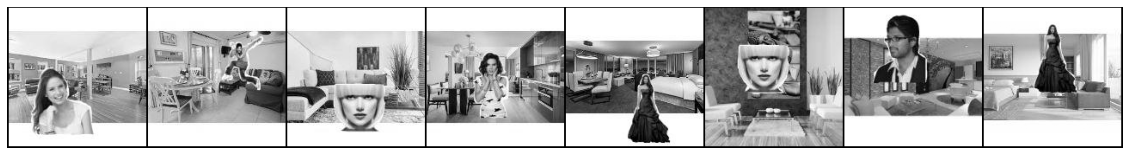

 After iteration:  200  ground truth  mask images:


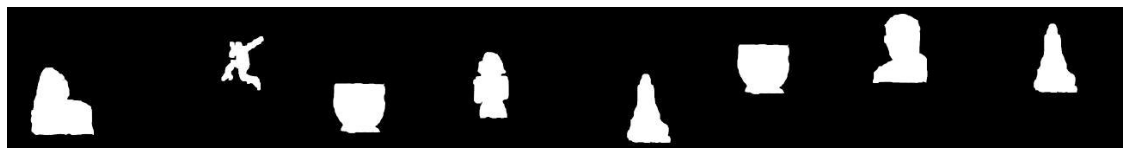

 After iteration:  200  Mask IoU: 0.9478972876254577
 After iteration:  200  predicted mask images:


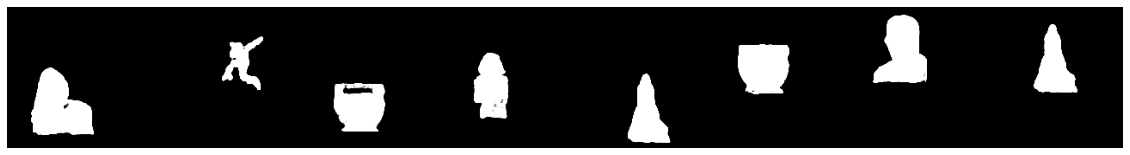

 After iteration:  200  ground truth depth images:


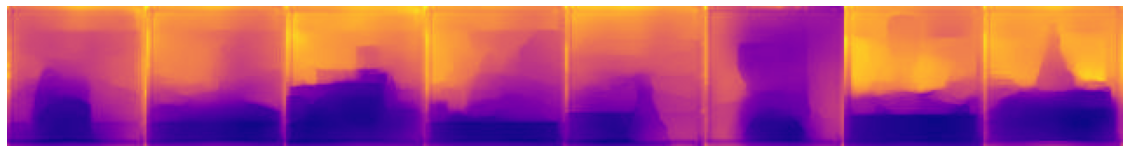

 After iteration:  200  predicted depth images:


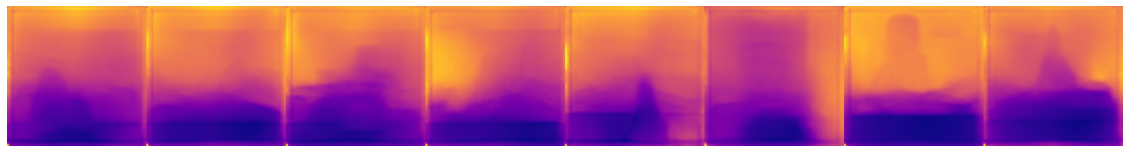

 After iteration:  300  Background images: 


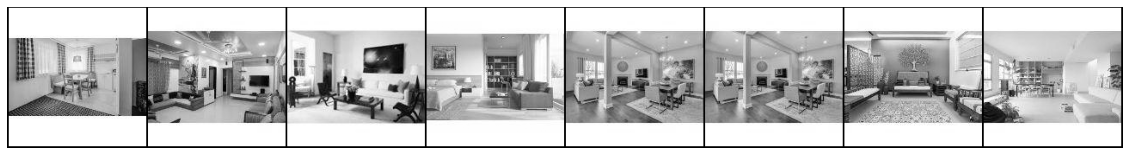

 After iteration:  300  foregound superimposed background images: 


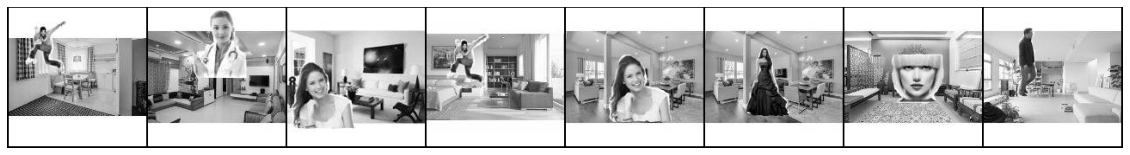

 After iteration:  300  ground truth  mask images:


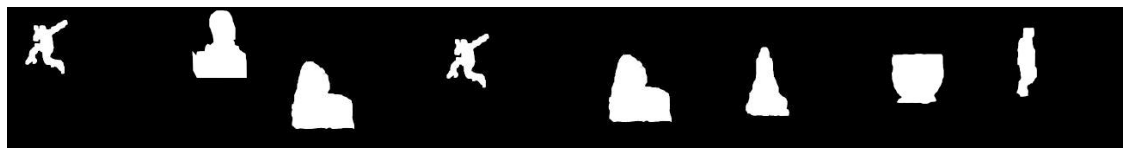

 After iteration:  300  Mask IoU: 0.9523079992020747
 After iteration:  300  predicted mask images:


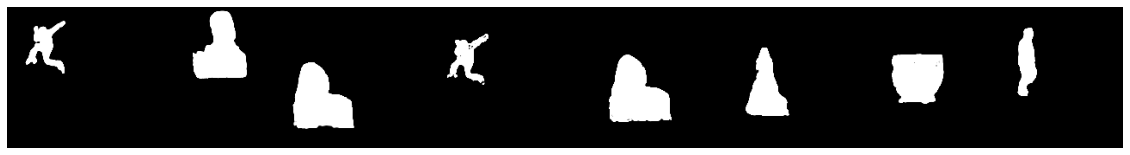

 After iteration:  300  ground truth depth images:


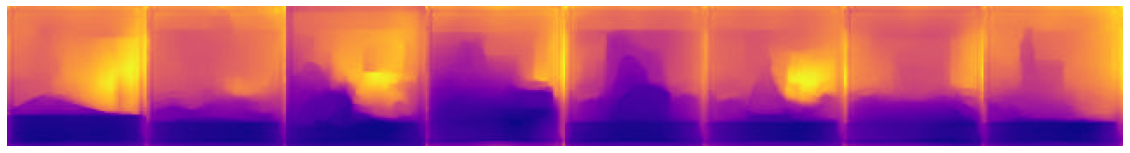

 After iteration:  300  predicted depth images:


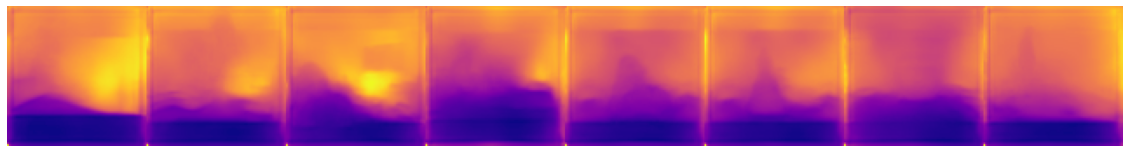

 After iteration:  399  Background images: 


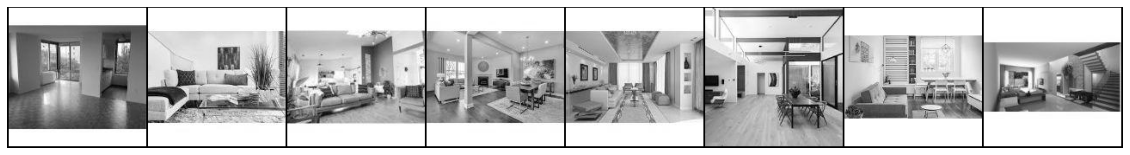

 After iteration:  399  foregound superimposed background images: 


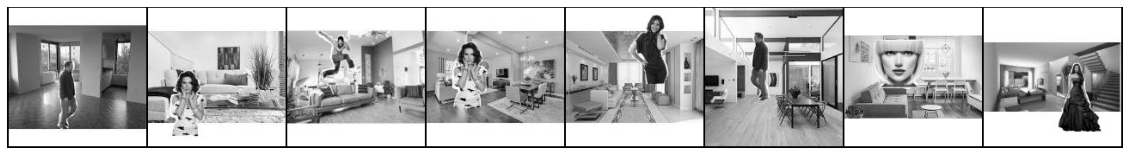

 After iteration:  399  ground truth  mask images:


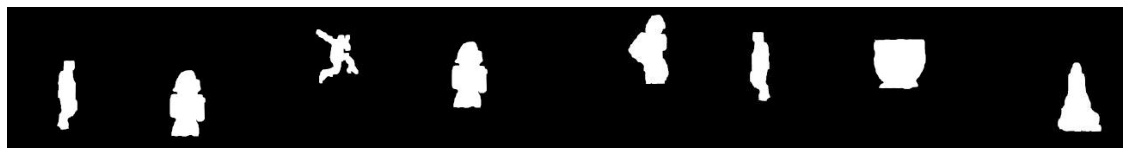

 After iteration:  399  Mask IoU: 0.9565858394563042
 After iteration:  399  predicted mask images:


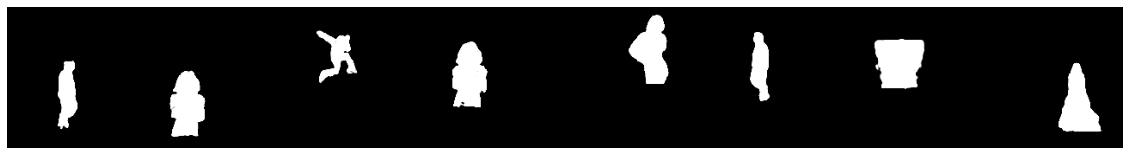

 After iteration:  399  ground truth depth images:


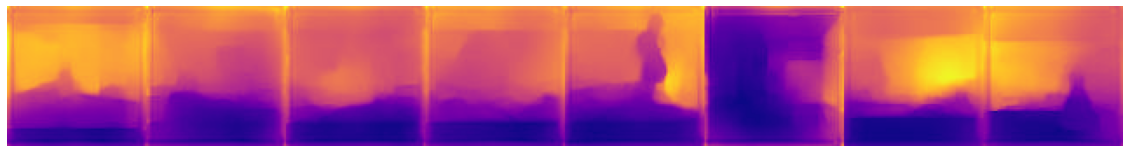

 After iteration:  399  predicted depth images:


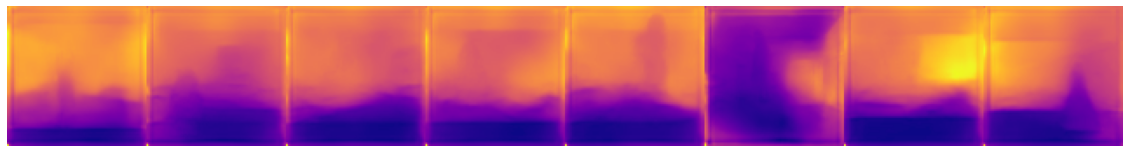

In [0]:
criteria1 = nn.BCEWithLogitsLoss()
criteria2 =  SSIM(window_size=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 100
#TEST_MODEL_PATH = '/content/drive/My Drive/eva4_final_project/models/0_5000.pth'
model.load_state_dict(torch.load(TEST_MODEL_PATH), strict=False)
model = model.to(device)
test(model, device, criteria1, criteria2, test_dl, writer, TEST_PLOT_PATH)

## Disable cprofile and dump the cprofile stats to a file

In [0]:
pr.disable()
pr.dump_stats(CPROFILE_STATS_PATH + "/cprofile_stats.txt")

## Collect tensorboard stats to a file

In [0]:
!ls -l runs

total 8
drwxr-xr-x 2 root root 4096 May 23 20:06 May23_20-06-05_7976e966b8d4
drwxr-xr-x 2 root root 4096 May 23 20:21 May23_20-21-02_7976e966b8d4


In [0]:
!mkdir -p '/content/drive/My Drive/eva4_final_project/final_api/tensor_board_final_stats'
!tar -zcvf '/content/drive/My Drive/eva4_final_project/final_api/tensor_board_final_stats/tensor_board_final_stats.tar.gz' runs


runs/
runs/May23_20-21-02_7976e966b8d4/
runs/May23_20-21-02_7976e966b8d4/events.out.tfevents.1590265263.7976e966b8d4.783.0
runs/May23_20-06-05_7976e966b8d4/
runs/May23_20-06-05_7976e966b8d4/events.out.tfevents.1590264367.7976e966b8d4.137.0


In [0]:
!ls -l '/content/drive/My Drive/eva4_final_project/final_api/tensor_board_final_stats/tensor_board_final_stats.tar.gz'

-rw------- 1 root root 880017 May 24 04:06 '/content/drive/My Drive/eva4_final_project/final_api/tensor_board_final_stats/tensor_board_final_stats.tar.gz'


## Show a few records of GPU profiler

In [0]:
df.head(10)


layer_idx  call_idx  ...    mem_all  mem_cached
0          0         0  ...   35588096   341835776
1          1         1  ...   56559616   341835776
2          2         2  ...   56559616   341835776
3          3         3  ...   56559616   341835776
4          4         4  ...   56559616   341835776
5          4         5  ...   77531136   341835776
6          5         6  ...   77531136   341835776
7          5         7  ...  405211136  1000341504
8          3         8  ...  405211136  1000341504
9          6         9  ...  405211136  1000341504

[10 rows x 7 columns]

## Collect GPU profiler stats to a file

In [0]:
GPU_PROFILER_STATS_PATH="/content/drive/My Drive/eva4_final_project/final_api/gpu_profiler_stats"
!mkdir -p "/content/drive/My Drive/eva4_final_project/final_api/gpu_profiler_stats"
df.to_csv(GPU_PROFILER_STATS_PATH + "/gpu_profiler_stats.csv")

## Conclusion:

In this project, I have worked on predicting Mask and Depth of given background and foregroud superimposed background images. I have used reduced UNet model of only 748K parameters (i.e. less than 1M parameters) and predicted mask and depth almost closer to the ground truth values. Mask IoU is around 0.95.

I have used various profiling tools: tensorboard, cprofile, GPU profiler as well as calculated MACS value for the model